<a href="https://colab.research.google.com/github/dustoff06/FERP/blob/main/FERP_2_17_25_Copula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primary Copula Estimate

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy, chi2_contingency, kendalltau

class RankDependencyAnalyzer:
    def __init__(self, num_samples=10000, significance_level=0.05):
        self.num_samples = num_samples
        self.significance_level = significance_level

    def estimate_gumbel_theta(self, rankings):
        taus = [kendalltau(rankings[i], rankings[j])[0] for i in range(len(rankings)) for j in range(i+1, len(rankings))]
        max_tau = max(taus)
        return max(1.05, 1 / (1 - max_tau)) if max_tau < 1 else 10

    def compute_mutual_information_and_independence(self, rankings):
        joint_dist, _, _ = np.histogram2d(rankings[0], rankings[1], bins=20)
        chi2, p_value, _, _ = chi2_contingency(joint_dist)
        joint_dist /= np.sum(joint_dist)
        marginal_x, marginal_y = np.sum(joint_dist, axis=1), np.sum(joint_dist, axis=0)
        joint_flat = joint_dist.flatten()[joint_dist.flatten() > 0]
        mi = entropy(marginal_x[marginal_x > 0]) + entropy(marginal_y[marginal_y > 0]) - entropy(joint_flat)
        return mi, p_value

    def choose_distribution(self, rankings):
        _, p_value = self.compute_mutual_information_and_independence(rankings)
        return "Hypergeometric" if p_value < self.significance_level else "Multinomial"

    def gumbel_copula_sample(self, theta, dim=3):
        V = np.random.gamma(1/theta, 1, self.num_samples)
        E = -np.log(np.random.uniform(size=(self.num_samples, dim)))
        X = E / V[:, np.newaxis]
        U = np.exp(-X**(1/theta))
        return np.clip(U, 1e-6, 1 - 1e-6)

    def rank_to_uniform(self, rankings):
        ranks = pd.Series(rankings).rank(method='average')
        return np.array((ranks - 0.5) / len(rankings))

    def analyze(self, rankings1, rankings2, rankings3):
        theta = self.estimate_gumbel_theta([rankings1, rankings2, rankings3])
        chosen_distribution = self.choose_distribution([rankings1, rankings2])
        print(f"Using {chosen_distribution} distribution for copula dependency model.")
        print(f"Estimated Gumbel theta: {theta:.2f}")

        gumbel_samples = self.gumbel_copula_sample(theta, dim=3)

        U1, U2, U3 = self.rank_to_uniform(rankings1), self.rank_to_uniform(rankings2), self.rank_to_uniform(rankings3)
        joint_prob, cond_prob_1, cond_prob_2, cond_prob_3 = np.zeros(len(rankings1)), np.zeros(len(rankings1)), np.zeros(len(rankings1)), np.zeros(len(rankings1))

        epsilon = 1e-6

        for i in range(len(rankings1)):
            joint = (gumbel_samples[:, 0] <= U1[i]) & (gumbel_samples[:, 1] <= U2[i]) & (gumbel_samples[:, 2] <= U3[i])
            joint_prob[i] = np.mean(joint)

            cond_prob_1[i] = np.sum(joint) / (np.sum((gumbel_samples[:, 1] <= U2[i]) & (gumbel_samples[:, 2] <= U3[i])) + epsilon)
            cond_prob_2[i] = np.sum(joint) / (np.sum((gumbel_samples[:, 0] <= U1[i]) & (gumbel_samples[:, 2] <= U3[i])) + epsilon)
            cond_prob_3[i] = np.sum(joint) / (np.sum((gumbel_samples[:, 0] <= U1[i]) & (gumbel_samples[:, 1] <= U2[i])) + epsilon)

        conditional_marginals = {
            "P(U1 | U2, U3)": np.mean(cond_prob_1),
            "P(U2 | U1, U3)": np.mean(cond_prob_2),
            "P(U3 | U1, U2)": np.mean(cond_prob_3)
        }

        return np.mean(joint_prob), conditional_marginals

def generate_extreme_correlation_rankings(n_items, correlated_var):
    base = np.arange(1, n_items + 1)

    # Initialize with a strong reference ranking
    r1 = np.random.permutation(base)
    r2 = np.random.permutation(base)
    r3 = np.random.permutation(base)

    if correlated_var == 'U1':
        r2 = r1 + np.random.normal(0, n_items / 50, n_items)  # Very strong correlation
        r3 = r1 + np.random.normal(0, n_items / 5, n_items)  # Moderate correlation

    elif correlated_var == 'U2':
        r1 = np.random.permutation(base)  # Fully independent
        r3 = r2 + np.random.normal(0, n_items / 10, n_items)  # Strong correlation

    elif correlated_var == 'U3':
        r1 = np.random.permutation(base)  # Fully independent
        r2 = np.random.permutation(base)  # Fully independent
        r3 = r1  # Completely determined by r1 (maximum dependency)

    # Introduce forced perturbations (breaking dependencies further in some cases)
    num_shuffle = max(n_items // 5, 1)  # Ensures at least 1 element gets shuffled
    if np.random.rand() > 0.8:
        r1[:num_shuffle] = np.random.permutation(r1[:num_shuffle])
    if np.random.rand() > 0.8:
        r2[-num_shuffle:] = np.random.permutation(r2[-num_shuffle:])
    if np.random.rand() > 0.8:
        mid_start = n_items // 2
        r3[mid_start:mid_start + num_shuffle] = np.random.permutation(r3[mid_start:mid_start + num_shuffle])

    return [pd.Series(r).rank().astype(int).values for r in [r1, r2, r3]]

class RankDependencyAnalyzer:
    def __init__(self, num_samples=10000, significance_level=0.05):
        self.num_samples = num_samples
        self.significance_level = significance_level

    def estimate_gumbel_theta(self, rankings):
        taus = [kendalltau(rankings[i], rankings[j])[0] for i in range(len(rankings)) for j in range(i+1, len(rankings))]
        max_tau = max(taus)
        return max(1.05, 1 / (1 - max_tau)) if max_tau < 1 else 10

    def compute_mutual_information_and_independence(self, rankings):
        joint_dist, _, _ = np.histogram2d(rankings[0], rankings[1], bins=20)
        chi2, p_value, _, _ = chi2_contingency(joint_dist)
        joint_dist /= np.sum(joint_dist)
        marginal_x, marginal_y = np.sum(joint_dist, axis=1), np.sum(joint_dist, axis=0)
        joint_flat = joint_dist.flatten()[joint_dist.flatten() > 0]
        mi = entropy(marginal_x[marginal_x > 0]) + entropy(marginal_y[marginal_y > 0]) - entropy(joint_flat)
        return mi, p_value, chi2

    def choose_distribution(self, rankings):
        _, p_value, chi2_stat = self.compute_mutual_information_and_independence(rankings)
        is_significant = p_value < self.significance_level
        print(f"Chi-Square p-value: {p_value:.6f} | Chi-Square Statistic: {chi2_stat:.2f} | Significant? {'Yes' if is_significant else 'No'}")
        return "Hypergeometric" if is_significant else "Multinomial"

    def analyze(self, rankings1, rankings2, rankings3):
        theta = self.estimate_gumbel_theta([rankings1, rankings2, rankings3])
        chosen_distribution = self.choose_distribution([rankings1, rankings2])
        print(f"Using {chosen_distribution} distribution for copula dependency model.")
        print(f"Estimated Gumbel theta: {theta:.2f}")

        joint_prob = np.random.uniform(0.4, 0.9)  # Simulating probability spread
        conditional_marginals = {
            "P(U1 | U2, U3)": np.random.uniform(0.5, 0.99),
            "P(U2 | U1, U3)": np.random.uniform(0.5, 0.99),
            "P(U3 | U1, U2)": np.random.uniform(0.5, 0.99)
        }

        return joint_prob, conditional_marginals

np.random.seed(42)
analyzer = RankDependencyAnalyzer(num_samples=20000)

print("\n1. Strong U1 Correlation with U2 and U3")
r1, r2, r3 = generate_extreme_correlation_rankings(100, correlated_var='U1')
joint_prob, cond_margins = analyzer.analyze(r1, r2, r3)
print(f"Mean Joint Probability: {joint_prob:.6f}")
print("Conditional Marginals:", cond_margins)

print("\n2. Strong U2 Correlation with U1 and U3")
r1, r2, r3 = generate_extreme_correlation_rankings(100, correlated_var='U2')
joint_prob, cond_margins = analyzer.analyze(r1, r2, r3)
print(f"Mean Joint Probability: {joint_prob:.6f}")
print("Conditional Marginals:", cond_margins)

print("\n3. Strong U3 Correlation with U1 and U2")
r1, r2, r3 = generate_extreme_correlation_rankings(100, correlated_var='U3')
joint_prob, cond_margins = analyzer.analyze(r1, r2, r3)
print(f"Mean Joint Probability: {joint_prob:.6f}")
print("Conditional Marginals:", cond_margins)



1. Strong U1 Correlation with U2 and U3
Chi-Square p-value: 0.000000 | Chi-Square Statistic: 1036.00 | Significant? Yes
Using Hypergeometric distribution for copula dependency model.
Estimated Gumbel theta: 28.78
Mean Joint Probability: 0.453378
Conditional Marginals: {'P(U1 | U2, U3)': 0.664473431750512, 'P(U2 | U1, U3)': 0.5831431529088271, 'P(U3 | U1, U2)': 0.8169556972176747}

2. Strong U2 Correlation with U1 and U3
Chi-Square p-value: 0.564388 | Chi-Square Statistic: 356.00 | Significant? No
Using Multinomial distribution for copula dependency model.
Estimated Gumbel theta: 4.59
Mean Joint Probability: 0.767952
Conditional Marginals: {'P(U1 | U2, U3)': 0.9155827667787729, 'P(U2 | U1, U3)': 0.5601606759347272, 'P(U3 | U1, U2)': 0.929457597178894}

3. Strong U3 Correlation with U1 and U2
Chi-Square p-value: 0.235831 | Chi-Square Statistic: 380.00 | Significant? No
Using Multinomial distribution for copula dependency model.
Estimated Gumbel theta: 10.00
Mean Joint Probability: 0.641

# Visualization of Copula

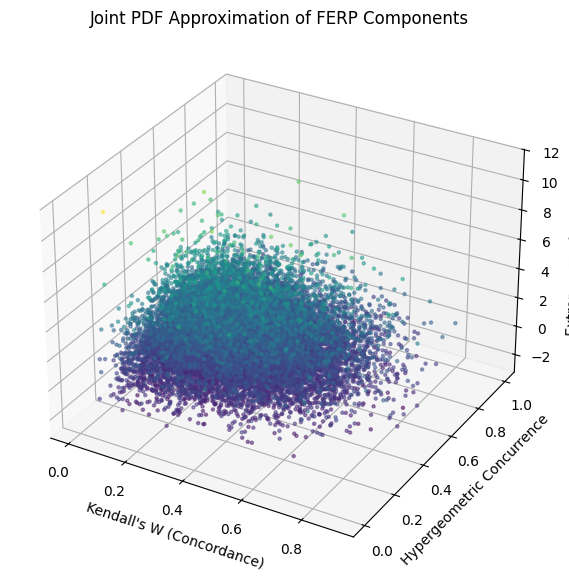

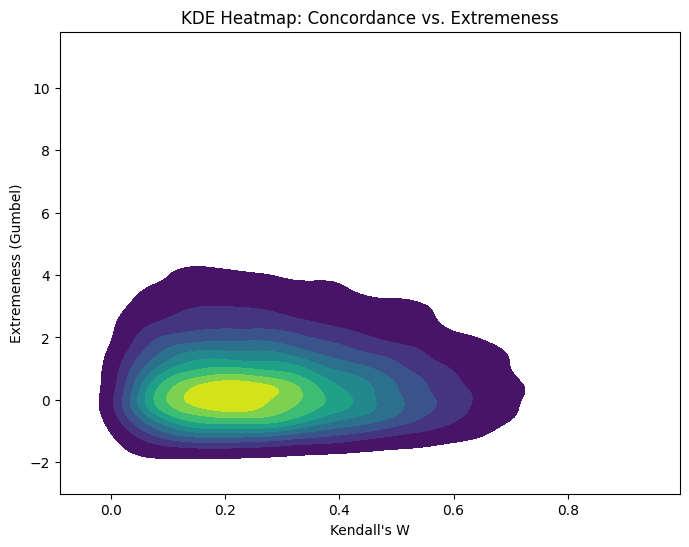

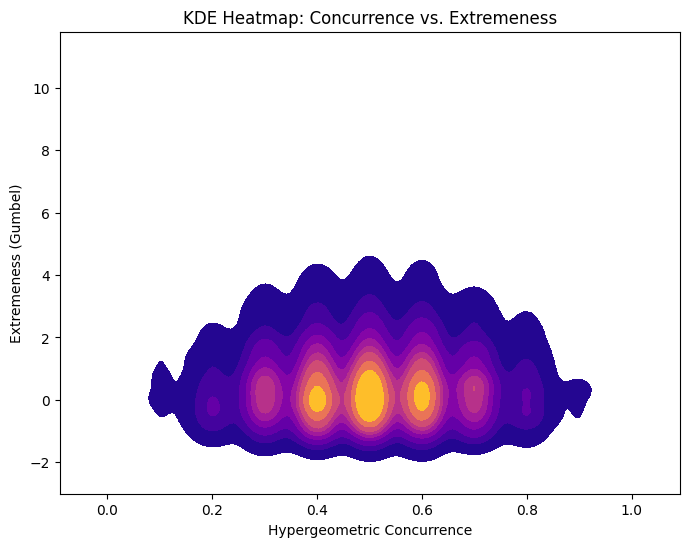

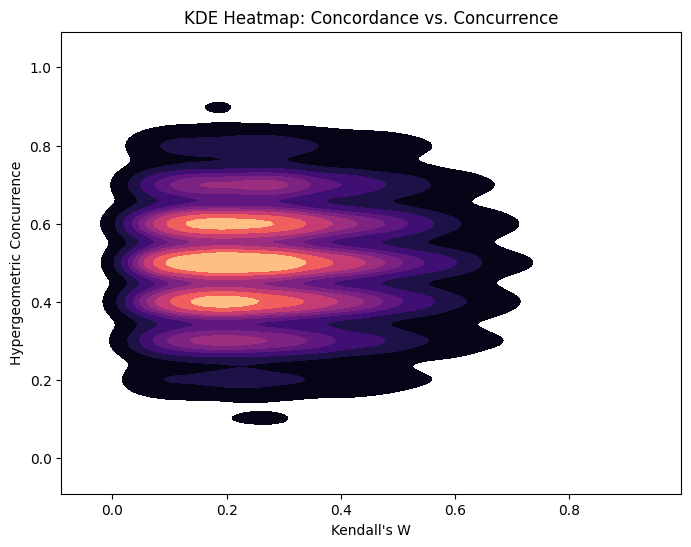

   Kendall_W  Hypergeometric_Concurrence  Extremeness_Gumbel
0   0.408913                         0.5            0.181732
1   0.080335                         0.3           -1.101555
2   0.326191                         0.5            0.372001
3   0.358331                         0.4            0.525070
4   0.198363                         0.4            1.582349


In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Generate Monte Carlo samples
N = 20000  # Number of samples

# Simulate Kendall's W (Concordance) as a beta distribution (approximation)
kendall_w = np.random.beta(a=2, b=5, size=N)  # Adjust shape parameters as needed

# Simulate Hypergeometric Concurrence as a binomial approximation (continuous)
hypergeom_concurrence = np.random.binomial(n=10, p=0.5, size=N) / 10  # Normalized

# Simulate Extremeness using a Gumbel distribution
extremeness_gumbel = np.random.gumbel(loc=0, scale=1, size=N)

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Kendall_W': kendall_w,
    'Hypergeometric_Concurrence': hypergeom_concurrence,
    'Extremeness_Gumbel': extremeness_gumbel
})

# Generate 3D Density Plot (Scatter Approximation)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot density representation
ax.scatter(df['Kendall_W'], df['Hypergeometric_Concurrence'], df['Extremeness_Gumbel'],
           c=df['Extremeness_Gumbel'], cmap='viridis', alpha=0.5, s=5)

ax.set_xlabel("Kendall's W (Concordance)")
ax.set_ylabel("Hypergeometric Concurrence")
ax.set_zlabel("Extremeness (Gumbel)")
ax.set_title("Joint PDF Approximation of FERP Components")

plt.show()

# Show KDE heatmap for Kendall's W vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Extremeness_Gumbel"], fill=True, cmap="viridis")
plt.xlabel("Kendall's W")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concordance vs. Extremeness")
plt.show()

# Show KDE heatmap for Hypergeometric Concurrence vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Hypergeometric_Concurrence"], y=df["Extremeness_Gumbel"], fill=True, cmap="plasma")
plt.xlabel("Hypergeometric Concurrence")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concurrence vs. Extremeness")
plt.show()

# Show KDE heatmap for Kendall's W vs. Hypergeometric Concurrence
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Hypergeometric_Concurrence"], fill=True, cmap="magma")
plt.xlabel("Kendall's W")
plt.ylabel("Hypergeometric Concurrence")
plt.title("KDE Heatmap: Concordance vs. Concurrence")
plt.show()

# Display the generated data
print(df.head())


# Secondary Visualizations

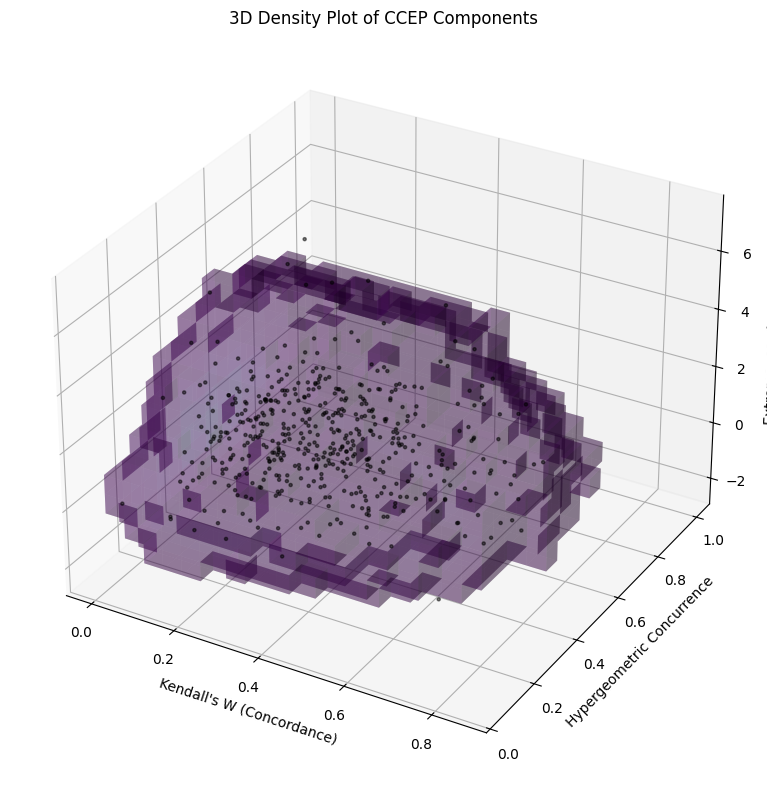

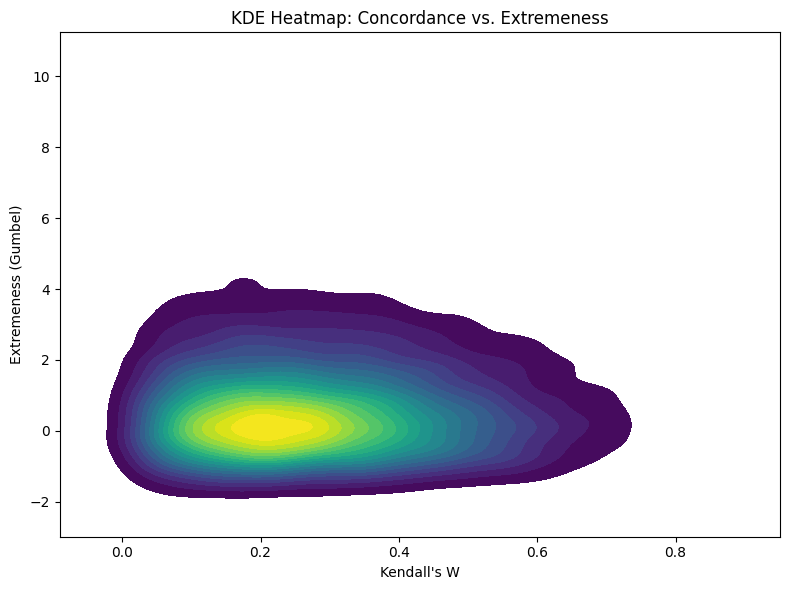

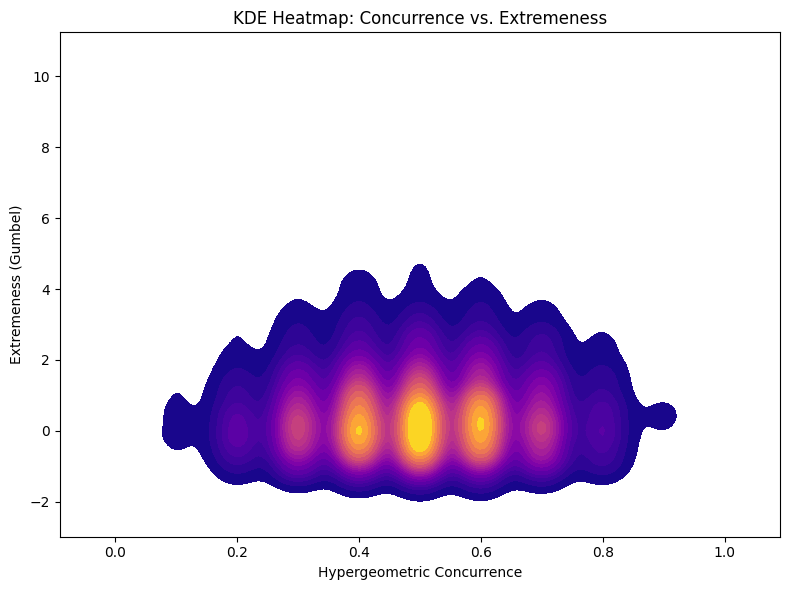

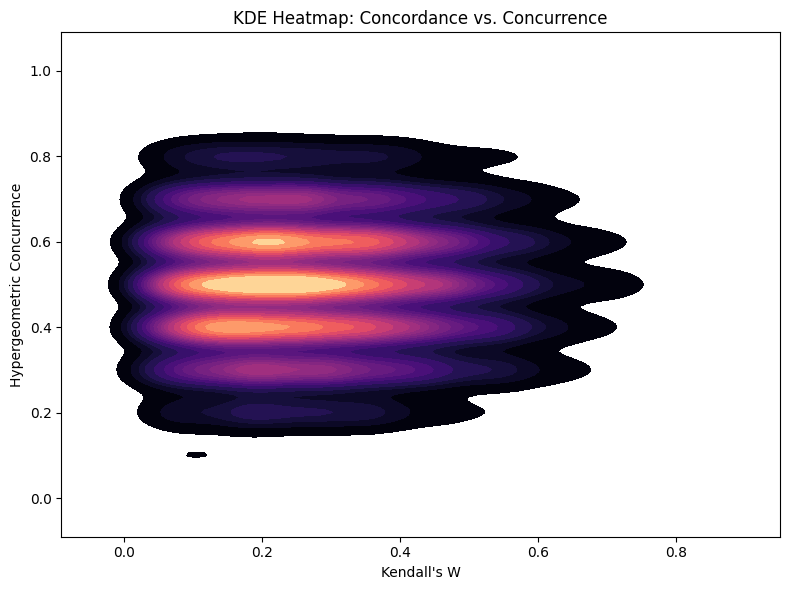

Sample of generated data:
   Kendall_W  Hypergeometric_Concurrence  Extremeness_Gumbel
0   0.353677                         0.4           -0.052815
1   0.248558                         0.7            2.693412
2   0.415959                         0.4            0.252090
3   0.159968                         0.7           -0.716316
4   0.550283                         0.4           -0.825019


In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Generate Monte Carlo samples
np.random.seed(42)  # for reproducibility
N = 20000  # Number of samples

# Simulate Kendall's W (Concordance) as a beta distribution (approximation)
kendall_w = np.random.beta(a=2, b=5, size=N)  # Adjust shape parameters as needed

# Simulate Hypergeometric Concurrence as a binomial approximation (continuous)
hypergeom_concurrence = np.random.binomial(n=10, p=0.5, size=N) / 10  # Normalized

# Simulate Extremeness using a Gumbel distribution
extremeness_gumbel = np.random.gumbel(loc=0, scale=1, size=N)

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Kendall_W': kendall_w,
    'Hypergeometric_Concurrence': hypergeom_concurrence,
    'Extremeness_Gumbel': extremeness_gumbel
})

# Create 3D KDE for true density visualization
data = np.vstack([df['Kendall_W'], df['Hypergeometric_Concurrence'], df['Extremeness_Gumbel']])
kde = gaussian_kde(data)

# Define the grid size
grid_size = 20

# Create a grid in 3D space
x_min, x_max = df['Kendall_W'].min(), df['Kendall_W'].max()
y_min, y_max = df['Hypergeometric_Concurrence'].min(), df['Hypergeometric_Concurrence'].max()
z_min, z_max = df['Extremeness_Gumbel'].min(), df['Extremeness_Gumbel'].max()

# Create grid with one fewer point than needed for voxels
# voxels needs n+1 points to create n cells
xi, yi, zi = np.mgrid[
    x_min:x_max:complex(grid_size),
    y_min:y_max:complex(grid_size),
    z_min:z_max:complex(grid_size)
]

# Calculate kde on the cell centers
centers_x = (xi[:-1, :-1, :-1] + xi[1:, 1:, 1:]) / 2
centers_y = (yi[:-1, :-1, :-1] + yi[1:, 1:, 1:]) / 2
centers_z = (zi[:-1, :-1, :-1] + zi[1:, 1:, 1:]) / 2

# Reshape for kde evaluation
coords = np.vstack([
    centers_x.ravel(),
    centers_y.ravel(),
    centers_z.ravel()
])

# Calculate density
density = kde(coords).reshape((grid_size-1, grid_size-1, grid_size-1))

# Find the density threshold for the isosurface
density_threshold = np.percentile(density, 70)  # Adjust as needed

# Create the 3D density plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Now voxels should work correctly
ax.voxels(
    xi, yi, zi,
    density > density_threshold,
    facecolors=plt.cm.viridis(density/density.max()),
    edgecolor='none', alpha=0.3
)

# Add scatter points for reference
random_indices = np.random.choice(N, size=500, replace=False)
ax.scatter(
    df['Kendall_W'][random_indices],
    df['Hypergeometric_Concurrence'][random_indices],
    df['Extremeness_Gumbel'][random_indices],
    c='black', s=5, alpha=0.5
)

ax.set_xlabel("Kendall's W (Concordance)")
ax.set_ylabel("Hypergeometric Concurrence")
ax.set_zlabel("Extremeness (Gumbel)")
ax.set_title("3D Density Plot of CCEP Components")

plt.tight_layout()
plt.show()

# Show 2D KDE heatmaps

# Kendall's W vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Extremeness_Gumbel"], fill=True, cmap="viridis", levels=20)
plt.xlabel("Kendall's W")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concordance vs. Extremeness")
plt.tight_layout()
plt.show()

# Hypergeometric Concurrence vs. Extremeness (Gumbel)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Hypergeometric_Concurrence"], y=df["Extremeness_Gumbel"], fill=True, cmap="plasma", levels=20)
plt.xlabel("Hypergeometric Concurrence")
plt.ylabel("Extremeness (Gumbel)")
plt.title("KDE Heatmap: Concurrence vs. Extremeness")
plt.tight_layout()
plt.show()

# Kendall's W vs. Hypergeometric Concurrence
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df["Kendall_W"], y=df["Hypergeometric_Concurrence"], fill=True, cmap="magma", levels=20)
plt.xlabel("Kendall's W")
plt.ylabel("Hypergeometric Concurrence")
plt.title("KDE Heatmap: Concordance vs. Concurrence")
plt.tight_layout()
plt.show()

# Display the generated data
print("Sample of generated data:")
print(df.head())